In [416]:
%pylab inline
%run params.py

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import pandas as pd
import random
import os
from scipy.stats import pearsonr
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from plotting_functions import *
from scipy.stats import ks_2samp
import random

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [417]:
dataset = pd.read_csv(os.path.join(DATAPATH, "constraint", "autosomal_perlocus_estimates.bed"))

In [418]:
strsets = ["lobSTR_ref_GRCh37_intergenic.bed",
           "lobSTR_ref_GRCh37_intron.bed",
           "lobSTR_ref_GRCh37_3utr.bed",
           "lobSTR_ref_GRCh37_5utr.bed",
           "lobSTR_ref_GRCh37_coding.bed",
          "lobSTR_ref_GRCh37_missenseconstrained.bed", "eSTRs.bed"]
colors = ["gray","darkgray","green","lightgreen","blue","cyan","pink"]

# 3D STRsets

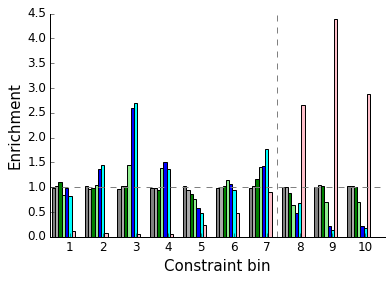

In [419]:
# Enrichment by bin
perc = 10
col = "zscore_1"
zbins = np.percentile(dataset[col], np.arange(0, 101, perc))
midpt = min([i for i in range(len(zbins)) if zbins[i] > 0])

fig = plt.figure()
ax = fig.add_subplot(111)

# For each set, get fold enrichment in each bin
xvals = np.arange(len(zbins)-1)  # the x locations for the groups
width = 0.10       # the width of the bars
ind = 0
labels = []
for strset in strsets:
    vals = []
    label = strset.split(".bed")[0].split("_")[-1]
    if label == "IDgenes":
        names = ["chrom","start","end","gene"]
    else: names = ["chrom","start","end"]
    if "missense" in label: label = "missense"
    setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", strset+".gz"), sep="\t", names=names)
    setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
    for i in range(len(zbins)-1):
        lb = zbins[i]
        ub = zbins[i+1]
        inbin = setdata[(setdata[col]>=lb) & (setdata[col]<ub)].shape[0]
        outbin = setdata.shape[0] - inbin
        enrich = (inbin*1.0/perc) / (outbin*1.0/(100-perc))
        vals.append(enrich)
    ax.bar(xvals + ind*width, vals, width=width, color=colors[ind], align="center")
    ind += 1
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_xticks(map(lambda x: x+0.5, range(len(zbins)-1)))
ax.set_xticklabels(range(1, len(zbins)), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.set_xlim(left=-0.1, right=len(vals)+0.1)
ax.axhline(1, linestyle="dashed", color="gray");
ax.axvline(midpt-1.2, linestyle="dashed", color="gray")
ax.set_xlabel("Constraint bin", size=15);
ax.set_ylabel("Enrichment", size=15);
fig.savefig(os.path.join(PLOTDIR, "Figure3_ConstraintBins.pdf"))

# 3E Expected by class

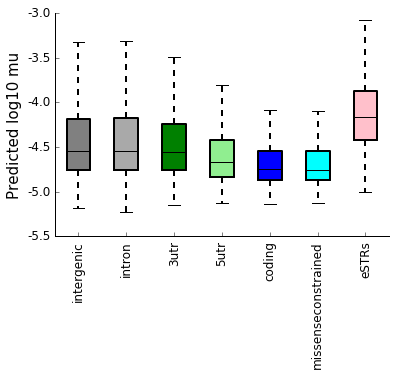

In [420]:
boxdata = []
labels = []

# For each set, get fold enrichment in each bin

for strset in strsets:
    vals = []
    label = strset.split(".bed")[0].split("_")[-1]
    labels.append(label)
    names = ["chrom","start","end"]
    setdata = pd.read_csv(os.path.join(DATAPATH, "strsets", strset+".gz"), sep="\t", names=names)
    setdata = pd.merge(setdata, dataset, on=["chrom","start"]).drop_duplicates()
    boxdata.append(setdata["pred_mu_1"])
    
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot(boxdata, sym="");

plt.setp(bp['boxes'], color='black', lw=2)
plt.setp(bp['whiskers'], color='black', lw=2)

for i in range(len(labels)):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    boxPolygon = Polygon(boxCoords, facecolor=colors[i])
    ax.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        ax.plot(medianX, medianY, 'k')
        
ax.set_xticklabels(labels, rotation=90, size=12);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.set_yticklabels(ax.get_yticks(), size=12);
ax.set_ylabel("Predicted log10 mu", size=15);
fig.savefig(os.path.join(PLOTDIR, "Figure3_ExpectedByClass.pdf"))